**извлечение признаков из текста на естественном языке**

классификатор текстов

частотный анализ с очисткой стоп-слов (TF)

Евгений Борисов borisov.e@solarl.ru

## библиотеки

In [1]:
import numpy as np
import pandas as pd
import re
import gzip

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [3]:
%matplotlib inline

In [4]:
pd.options.display.max_colwidth = 200  

## тексты

In [5]:
# загружаем тексты
data = pd.read_pickle('../data/text/news.pkl.gz')
print('записей:',len(data))

записей: 3196


In [6]:
data.sample(2)

,text,tag
2124,"Спорт\n\nПавел Мамаев прокомментировал слова экс-наставника «быков» Олега Кононова, заявившего, что «Мамаев после вечеринки в Монте-Карло так и не пришел в себя».\n\n«Олег Георгиевич, не ожидал от...",sport
2829,"17:23 - 12.12.2016\n\nТакже это касается и официальных порталов госорганов, сайтов государственных и муниципальных предприятий.\n\nКак отметили в ведомстве, надзорный орган не будет применять меры...",tech


---

In [7]:
from nltk import download as nltk_download
nltk_download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mechanoid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
# from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords

stopwords = set(nltk_stopwords.words('russian') )

In [9]:
# with gzip.open('../data/text/stop-nltk.txt.gz','rt',encoding='utf-8') as f: 
#     stopwords = set([ w.strip() for w in  f.read().split() if w.strip() ] )

# print('количество стоп-слов:',len(stopwords))
# sorted(stopwords)

In [10]:
%%time 

data['text_clean'] = data['text'].str.lower() # приведение в lowercase

# замена символов-разделителей (-,_) на пробел
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'\W', ' ', s))
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'_', ' ', s))

# замена цифр
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'\b\d+\b', ' ', s))

# делим строки на слова (токенизация)
data['text_clean'] = data['text_clean'].apply(lambda t: [ w.strip() for w in t.split() if len(w.strip())>2 ] )

# удаление лишних слов 
data['text_clean'] = data['text_clean'].apply(lambda t:[w for w in t if w not in stopwords])

# стемминг, выделение основы слова
# data['text_clean'] = data['text_clean'].apply( lambda t: Stemmer('russian').stemWords(t) )
# data['text_clean'] = data['text_clean'].apply(lambda t:[ SnowballStemmer('russian').stem(w) for w in t if w])


CPU times: user 1.88 s, sys: 97.8 ms, total: 1.98 s
Wall time: 2.28 s


In [11]:
data['text_clean'] = data['text_clean'].apply(lambda t:' '.join(t))

In [12]:
data[['text_clean']].sample(2)

,text_clean
2305,вчера ночью скончалась летняя женщина которая получила многочисленные ожоги взрыве бытового газа многоквартирном доме советской гавани напомним взрыв бытового газа произошел квартире пятом этаже м...
1701,корпорация газпром заключила соглашение иранской национальной нефтяной компанией добыче сырой нефти двух местарождениях это следует пресс релиза министерства энергетики россии информацию подтверди...


##  HashingVectorizer

In [13]:
from sklearn.feature_extraction.text import HashingVectorizer

tf = HashingVectorizer(n_features=16384, norm='l2')
tf.fit( data['text_clean'])

HashingVectorizer(alternate_sign=True, analyzer='word', binary=False,
                  decode_error='strict', dtype=<class 'numpy.float64'>,
                  encoding='utf-8', input='content', lowercase=True,
                  n_features=16384, ngram_range=(1, 1), norm='l2',
                  preprocessor=None, stop_words=None, strip_accents=None,
                  token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None)

## формируем датасеты

In [14]:
X = tf.transform( data['text_clean'] )
X.shape

(3196, 16384)

In [15]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [16]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9])

---

In [17]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.9, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((319, 16384), (319,), (2877, 16384), (2877,))

## обучаем

In [18]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19)
clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.19,
              validation_fraction=0.1, verbose=0, warm_start=False)

## тестируем

In [19]:
o = clf.predict(X_train)

In [20]:
accuracy_score(y_train,o)

1.0

---

In [21]:
o = clf.predict(X_test)

In [22]:
accuracy_score(y_test,o)

0.7288842544316997

In [23]:
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       0.82      0.74      0.78       227
           1       0.69      0.73      0.71       319
           2       0.67      0.68      0.68       240
           3       0.36      0.19      0.25        86
           4       0.75      0.82      0.78       396
           5       0.70      0.89      0.78       542
           6       0.50      0.29      0.37        58
           7       0.70      0.34      0.46        41
           8       0.80      0.86      0.83       200
           9       0.45      0.30      0.36       133
          10       0.92      0.86      0.89       340
          11       0.69      0.62      0.65       262
          12       0.91      0.30      0.45        33

    accuracy                           0.73      2877
   macro avg       0.69      0.59      0.62      2877
weighted avg       0.72      0.73      0.72      2877



---

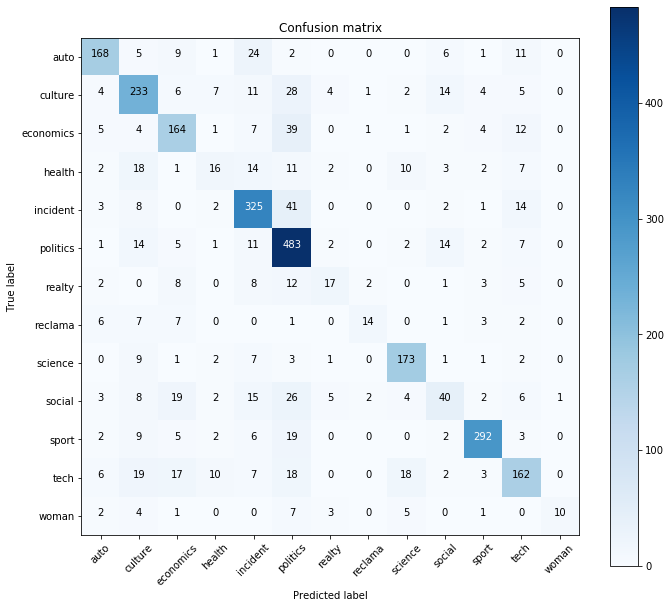

In [24]:
from matplotlib import pyplot as plt
import itertools

classes = sorted(labels.keys())
cm = confusion_matrix(y_test,o)
tick_marks = np.arange(len(classes))

plt.figure(figsize=(10,9))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.title('Confusion matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

plt.show()

---

In [25]:
o = clf.predict(X)

In [26]:
labels_inv = { labels[k]:k for k in labels}
# labels_inv

In [27]:
i = np.random.randint(len(data))
print('tag:',data.iloc[i,1])
print('predict:',labels_inv[o[i]])
print('- - - - - - - - - - - - - - - - - - \n')
print(data.iloc[i,0])


tag: economics
predict: economics
- - - - - - - - - - - - - - - - - - 

С начала года инфляция перешагнула двузначную отметку

9 декабря 2016 в 16:12

FINANCE.TUT.BY

Инфляция в ноябре в Беларуси составила 0,8%, сообщает Белстат. Больше всего в прошлом месяце выросли цены на продовольственные товары (+1,5%). С начала года инфляция составила 10,1%.

Фото: Reuters

Непродовольственные товары в ноябре подорожали на 0,1%, а с начала года — на 7,4%.

Услуги, на которые в октябре зафиксировали дефляцию, за прошлый месяц стали дороже на 0,3%, а за 10 месяцев этого года — на 16,3%.

При этом цены на продовольственные товары с начала года подскочили на 9,4%.

В правительстве рассчитывают, что инфляцию в 2016 году в Беларуси получится удержать в пределах 12%.
